# Detecting Potato Diseases with Convolutional Neural Networks

"The Dataset consists of images of potato leaves affected by two different classes of diseases: Early blight and Late blight. It also contains images of Healthy leaves. Each class represents a distinct category that the model aims to identify

Late Blight: Late blight of potato is a disease caused by fungus Phytophthora infestans.

Early Blight: Early blight of potato is a disease caused by the fungus Alternaria solani

Healthy: Uninfected or healthy plant

dataset link

https://www.kaggle.com/datasets/rizwan123456789/potato-disease-leaf-datasetpld

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rizwan123456789/potato-disease-leaf-datasetpld")

print("Path to dataset files:", path)

100%|██████████| 37.4M/37.4M [00:00<00:00, 113MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/rizwan123456789/potato-disease-leaf-datasetpld/versions/1


In [5]:
import os
os.listdir(path)

['PLD_3_Classes_256']

In [6]:
data_path = os.path.join(path, "PLD_3_Classes_256")
data_path

'/root/.cache/kagglehub/datasets/rizwan123456789/potato-disease-leaf-datasetpld/versions/1/PLD_3_Classes_256'

In [ ]:
# import os
# data_path = os.path.join(path, "PLD_3_Classes_256")
# dataset = tf.keras.preprocessing.image_dataset_from_directory(
# data_path,
#   shuffle=True,
#   image_size = (IMAGE_SIZE,IMAGE_SIZE),
#   batch_size = BATCH_SIZE
# )


In [7]:
train_path = os.path.join(path, "PLD_3_Classes_256", "Training")
test_path = os.path.join(path, "PLD_3_Classes_256", "Testing")
val_path = os.path.join(path, "PLD_3_Classes_256", "Validation")


In [8]:
train_path

'/root/.cache/kagglehub/datasets/rizwan123456789/potato-disease-leaf-datasetpld/versions/1/PLD_3_Classes_256/Training'

In [9]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_path,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    shuffle=False,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)


Found 3251 files belonging to 3 classes.
Found 416 files belonging to 3 classes.
Found 405 files belonging to 3 classes.


In [ ]:
class_names = train_ds.class_names
class_names

['Early_Blight', 'Healthy', 'Late_Blight']

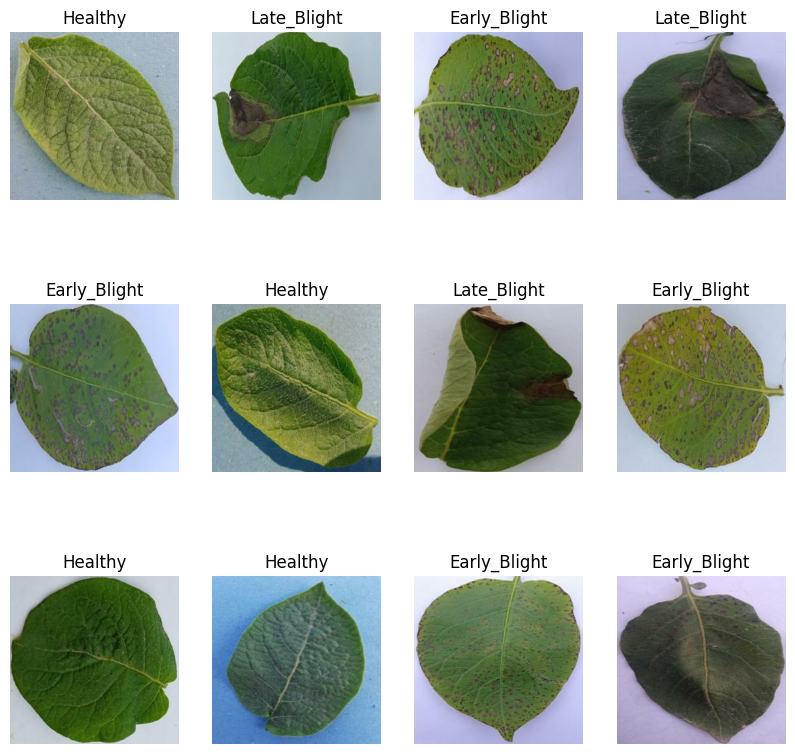

In [ ]:

plt.figure(figsize=(10,10))
for image_batch, label_batch in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

In [ ]:
# resize_and_rescale = tf.keras.Sequential([
#     #layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),   # optional if image_dataset already resized
#     layers.Rescaling(1.0/255)
# ])

In [ ]:
# Data augmentation — apply only to training
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
    # add other transforms if you like
])

“Run the map() operation (augmentation, preprocessing, etc.) in parallel, and automatically decide the optimal number of CPU threads to use.”

Much faster data preprocessing

Image augmentation (flip, rotate, zoom) is expensive.
Without AUTOTUNE → TensorFlow processes one batch at a time, sequentially.
With AUTOTUNE → TensorFlow uses multiple CPU cores to process batches at once.

This means your GPU gets data faster → better GPU utilization → quicker training.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
# train_ds = train_ds.map(lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=AUTOTUNE)
# val_ds   = val_ds.map(lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=AUTOTUNE)
# test_ds  = test_ds.map(lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=AUTOTUNE)

In [ ]:
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                        num_parallel_calls=AUTOTUNE)


cache():
Save the dataset in RAM so training does not reload images from disk every epoch.

prefetch(AUTOTUNE):
Prepare the next batch while the GPU is training on the current batch.

Result:

GPU never waits

Training is significantly faster

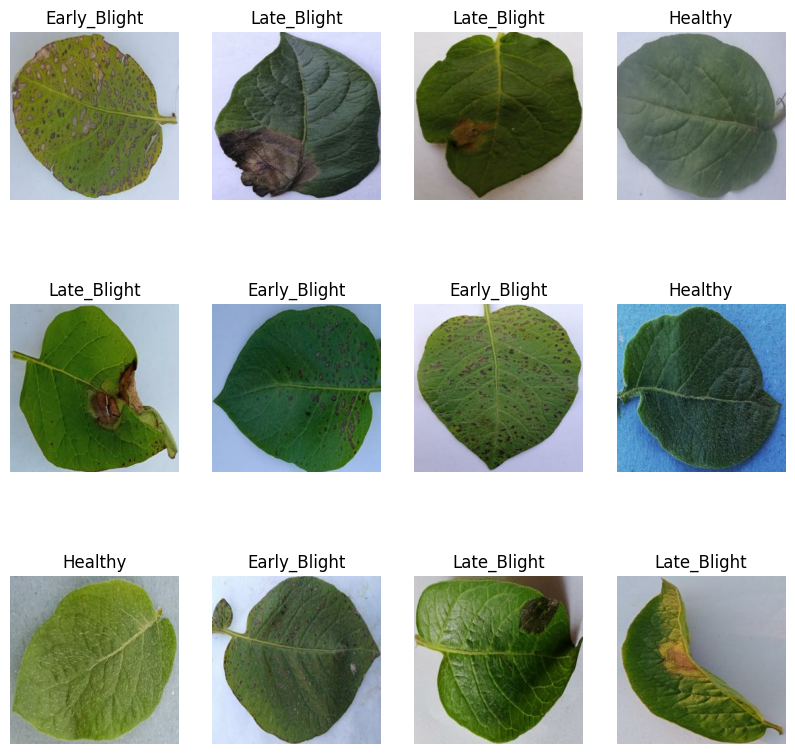

In [ ]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")


In [ ]:
# n_classes = 3
# model = models.Sequential([
#     layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
#     layers.Rescaling(1./255),            # normalize here (keep consistent)
#     layers.Conv2D(32, 3, activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Conv2D(64, 3, activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Conv2D(128, 3, activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Flatten(),
#     layers.Dense(128, activation='relu'),
#     layers.Dropout(0.5),
#     layers.Dense(n_classes, activation='softmax')
# ])


In [ ]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    #resize_and_rescale,  # This layer sets the input shape implicitly
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

# Build with only the image shape, no batch size
model.build(input_shape=(None, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))



/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

Use from_logits=False when your last layer has softmax/sigmoid.

Use from_logits=True when your last layer has NO activation.

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',      # stop based on validation loss
    patience=5,              # wait 5 epochs before stopping
    restore_best_weights=True,  # load best model weights
    min_delta=0.001          # minimum improvement required
)


In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 62s 505ms/step - accuracy: 0.3938 - loss: 1.8376 - val_accuracy: 0.5024 - val_loss: 0.9834
Epoch 2/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 46s 442ms/step - accuracy: 0.5432 - loss: 0.9469 - val_accuracy: 0.5841 - val_loss: 0.8789
Epoch 3/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 80s 426ms/step - accuracy: 0.5595 - loss: 0.9186 - val_accuracy: 0.5865 - val_loss: 0.8980
Epoch 4/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 82s 424ms/step - accuracy: 0.6077 - loss: 0.8827 - val_accuracy: 0.6202 - val_loss: 0.8576
Epoch 5/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 82s 434ms/step - accuracy: 0.6168 - loss: 0.8431 - val_accuracy: 0.6226 - val_loss: 0.7625
Epoch 6/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 44s 423ms/step - accuracy: 0.6746 - loss: 0.7667 - val_accuracy: 0.7740 - val_loss: 0.5421
Epoch 7/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 44s 427ms/step - accuracy: 0.7640 - loss: 0.5785 - val_accuracy: 0.8005 - val_loss: 0.5219
Epoch 8/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 82s 430ms/step - accuracy: 0.7996 - loss: 0

In [ ]:
scores = model.evaluate(test_ds)

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - accuracy: 0.9460 - loss: 0.1663


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

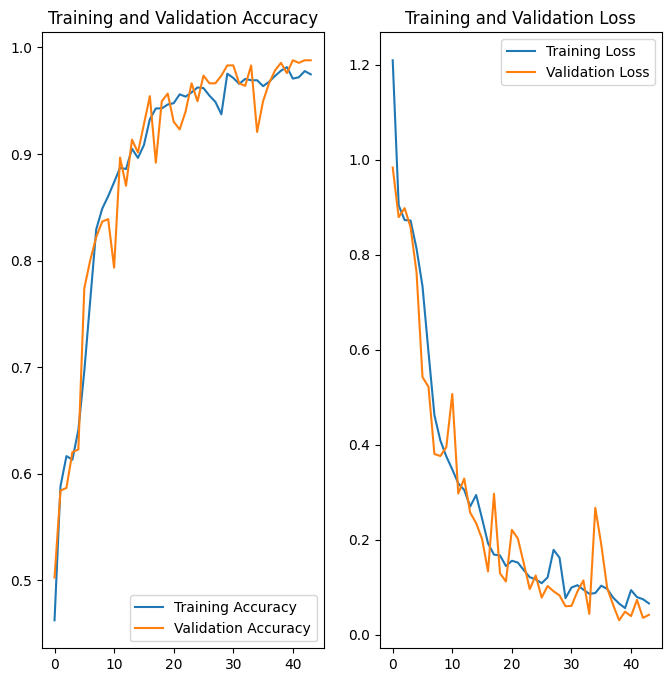

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))   # number of epochs actually trained

plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


first image to predict
actual label: Early_Blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
predicted label: Early_Blight


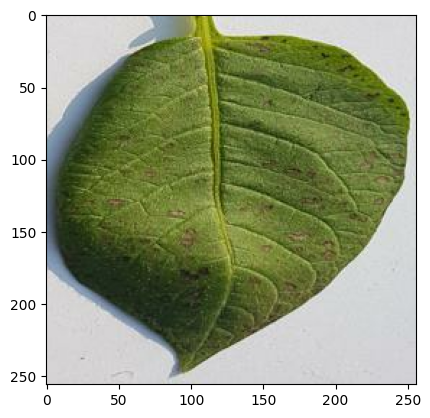

In [ ]:
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])


Actual label: Early_Blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted: Early_Blight


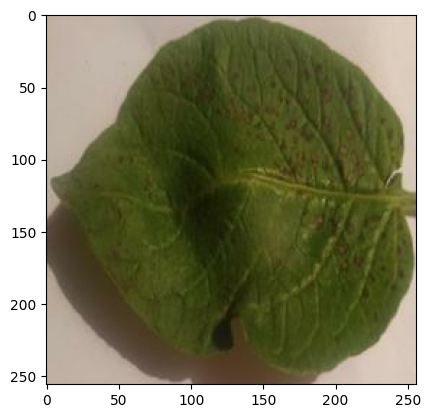

In [ ]:
test_list = list(test_ds.unbatch())
image_15, label_15 = test_list[40]   # 0-based index  11

image_15 = image_15.numpy().astype("uint8")
label_15 = label_15.numpy()

plt.imshow(image_15)
print("Actual label:", class_names[label_15])

prediction = model.predict(tf.expand_dims(image_15, axis=0))
print("Predicted:", class_names[np.argmax(prediction)])


In [ ]:
model.save("potato_model.h5")


In [ ]:
loaded_model = tf.keras.models.load_model("potato_model.h5")


In [ ]:
# from tensorflow.keras.callbacks import ModelCheckpoint

# checkpoint = ModelCheckpoint(
#     "best_model.h5",
#     monitor='val_loss',
#     save_best_only=True,
#     verbose=1
# )

# history = model.fit(
#     train_ds,
#     validation_data=val_ds,
#     epochs=50,
#     callbacks=[early_stop, checkpoint]
# )



In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


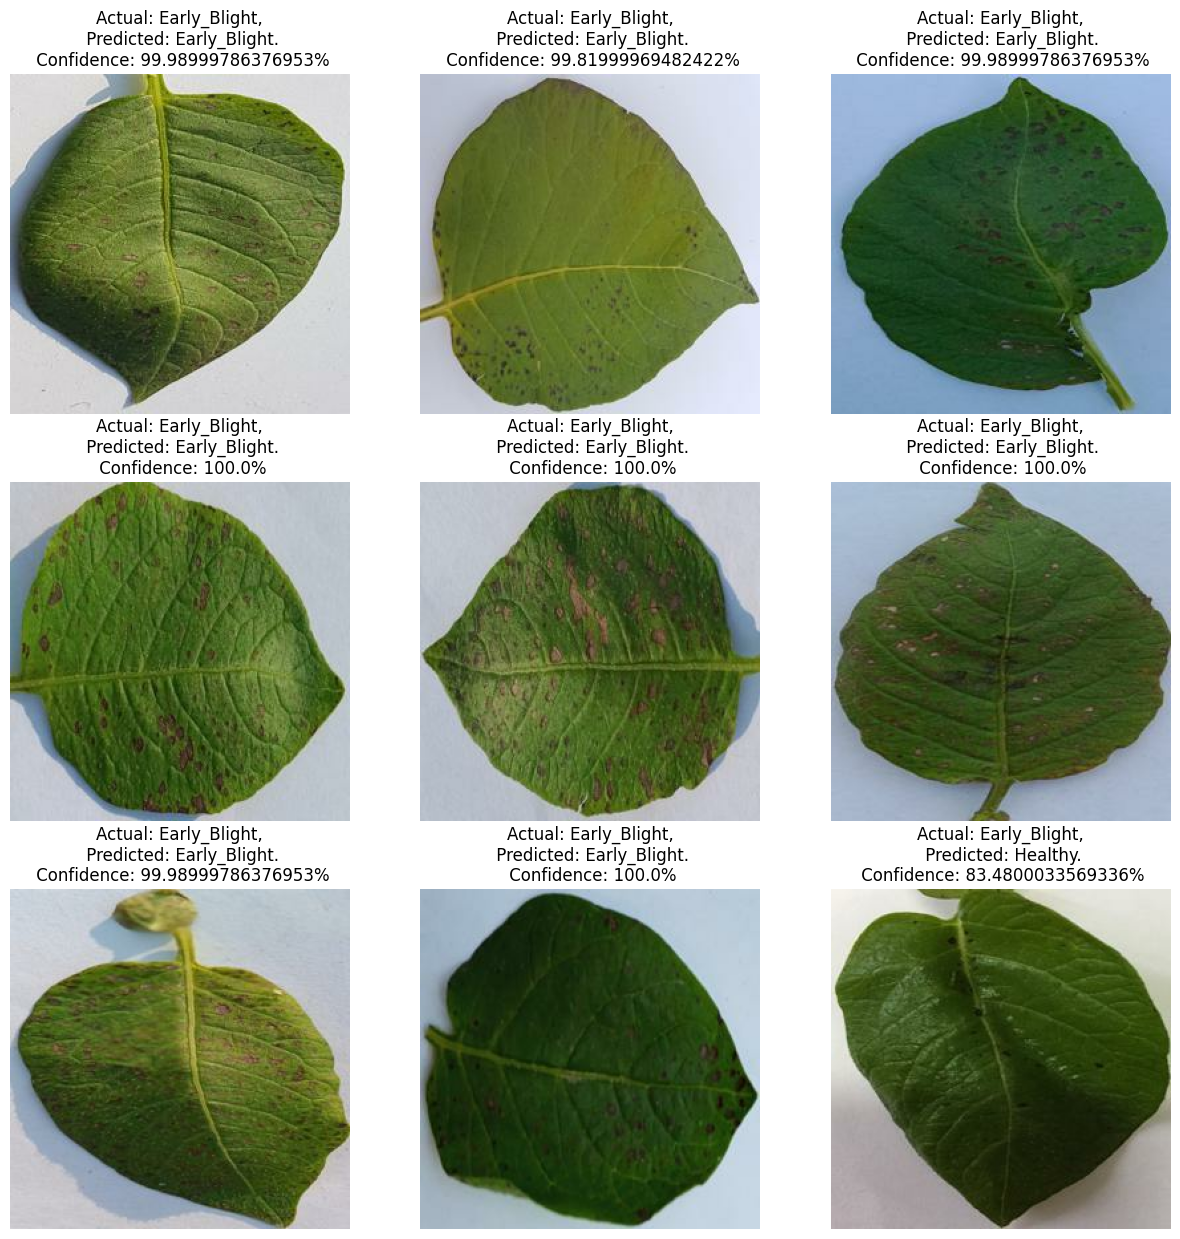

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

